In [1]:
import torch
from skimage import io, transform
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


## UNET
- UNet is a particular type of CNN, named after its U shape
- [Original paper](https://arxiv.org/pdf/1505.04597.pdf)
<p align="center">
<img src="unet.png" width="1000" title="Image." >
</p>

In [2]:
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 3, padding = 1):
        super().__init__()

        self.activation_fn = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = kernel_size, padding = padding)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = kernel_size, padding = padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.activation_fn(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation_fn(x)
        return x
    
class down_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = conv_block(in_channels, out_channels)
        self.pool = nn.MaxPool2d((2,2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x,p

class up_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 2, stride = 2, padding = 0)
        self.conv = conv_block(out_channels+out_channels, out_channels)
    
    def forward(self, inputs, skip): #inputs [bs,30,7,7]
        x = self.up(inputs) #inputs [bs,20,14,14]
        x = torch.cat([x, skip], axis=1) # if skip is of size [bs,50,14,14]. then x is now of size [bs,70,14,14]
        x = self.conv(x) # [bs, out_channels, 14,14]
        return x


class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels = 1, f = [64,128,256,512,1024]):
        super().__init__()
        
        #f = [8,8,8,8,8]

        self.encoder1 = down_block(in_channels, f[0])
        self.encoder2 = down_block(f[0],f[1])
        self.encoder3 = down_block(f[1],f[2])
        self.encoder4 = down_block(f[2],f[3])

        self.bottleneck = conv_block(f[3],f[4])

        self.decoder1 = up_block(f[4],f[3])
        self.decoder2 = up_block(f[3],f[2])
        self.decoder3 = up_block(f[2],f[1])
        self.decoder4 = up_block(f[1],f[0])

        self.outputs = nn.Conv2d(f[0], out_channels, kernel_size = 1, padding = 0)
        self.sigmoid_layer = nn.Sigmoid()

    def forward(self, inputs):
        c1, p1 = self.encoder1(inputs)
        c2, p2 = self.encoder2(p1)
        c3, p3 = self.encoder3(p2)
        c4, p4 = self.encoder4(p3)

        bn = self.bottleneck(p4)

        d1 = self.decoder1(bn, c4)
        d2 = self.decoder2(d1, c3)
        d3 = self.decoder3(d2, c2)
        d4 = self.decoder4(d3, c1)

        outputs = self.outputs(d4)
        outputs = self.sigmoid_layer(outputs)
        
        plot = True
        if plot:
            print('Input shape', inputs.shape)
            print('After layer 1', p1.shape)
            print('After layer 2', p2.shape)
            print('After layer 3', p3.shape)
            print('After layer 4', p4.shape)
            print('After bn', bn.shape)
            print('After layer 6', d1.shape)
            print('After layer 7', d2.shape)
            print('After layer 8', d3.shape)
            print('After layer 9', d4.shape)
            print('Output shape', outputs.shape)

        return outputs
UNet = UNet()

x = torch.zeros([1,3,256,256])
y = UNet(x)

Input shape torch.Size([1, 3, 256, 256])
After layer 1 torch.Size([1, 64, 128, 128])
After layer 2 torch.Size([1, 128, 64, 64])
After layer 3 torch.Size([1, 256, 32, 32])
After layer 4 torch.Size([1, 512, 16, 16])
After bn torch.Size([1, 1024, 16, 16])
After layer 6 torch.Size([1, 512, 32, 32])
After layer 7 torch.Size([1, 256, 64, 64])
After layer 8 torch.Size([1, 128, 128, 128])
After layer 9 torch.Size([1, 64, 256, 256])
Output shape torch.Size([1, 1, 256, 256])


## Segmentation

- Image segmentation is the task of partitioning an image, or identifying an object in an image
- Particular value in medical imaging, highlighting objects of interest

<p align="center">
<img src="./DRIVE/training/images/21_training.png" width="200" title="Image." >
</p>
<p align="center">
<img src="./DRIVE/training/1st_manual/21_manual1.png" width="200" title="Image." >
</p>

- The target image is a binary image, where pixels = 0 are background and pixels = 1 are foreground. We want the network to output a binary image replicating this.

In [4]:
def get_paths(base_path='./DRIVE/'):
    train_im_paths = []
    train_gt_paths = []
    test_im_paths = []
    test_gt_paths = []
    
    for i in range(21, 41):
        train_im_paths.append(base_path + 'training/images/%d_training.tif'%(i))
        train_gt_paths.append(base_path + 'training/1st_manual/%d_manual1.gif'%(i))

    for i in range(1, 21):
        test_im_paths.append(base_path + 'test/images/%d_test.tif'%(i))
        test_gt_paths.append(base_path + 'test/1st_manual/%d_manual1.gif'%(i))
        
    train_paths = [train_im_paths,train_gt_paths]
    test_paths = [test_im_paths,test_gt_paths]
    return train_paths, test_paths

In [5]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, paths):
        # TODO
        # 1. Initialize file paths or a list of file names. 
        self.im_paths = paths[0]
        self.gt_paths = paths[1]
        self.preprocesses = T.Compose([
            T.Resize((256,256)),
            T.ToTensor(),
        ])
        pass
    def __getitem__(self, index):
        # TODO
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        image = Image.open(self.im_paths[index])
        label = Image.open(self.gt_paths[index])
        # 2. Preprocess the data (e.g. torchvision.Transform).
        
        image = self.preprocesses(image)
        label = self.preprocesses(label)
        
        #Ensure gt is binary
        label[label>.5] = 1
        label[label<=.5]=0
        # 3. Return a data pair (e.g. image and label).
        return image, label
        
    def __len__(self):
        return len(self.im_paths)
    

train_paths, test_paths = get_paths()
    
custom_dataset = CustomDataset(train_paths)
train_loader = torch.utils.data.DataLoader(dataset=custom_dataset,
                                           batch_size=4, 
                                           shuffle=True)


In [6]:
print(train_paths[0])
print(train_paths[1])

['./DRIVE/training/images/21_training.tif', './DRIVE/training/images/22_training.tif', './DRIVE/training/images/23_training.tif', './DRIVE/training/images/24_training.tif', './DRIVE/training/images/25_training.tif', './DRIVE/training/images/26_training.tif', './DRIVE/training/images/27_training.tif', './DRIVE/training/images/28_training.tif', './DRIVE/training/images/29_training.tif', './DRIVE/training/images/30_training.tif', './DRIVE/training/images/31_training.tif', './DRIVE/training/images/32_training.tif', './DRIVE/training/images/33_training.tif', './DRIVE/training/images/34_training.tif', './DRIVE/training/images/35_training.tif', './DRIVE/training/images/36_training.tif', './DRIVE/training/images/37_training.tif', './DRIVE/training/images/38_training.tif', './DRIVE/training/images/39_training.tif', './DRIVE/training/images/40_training.tif']
['./DRIVE/training/1st_manual/21_manual1.gif', './DRIVE/training/1st_manual/22_manual1.gif', './DRIVE/training/1st_manual/23_manual1.gif', 

In [8]:
print(train_loader)
data_iter = iter(train_loader)
image,label = next(data_iter)
print(image.size())
print(label.size())

label = torch.squeeze(label)
print(label.size())

torch.Size([4, 3, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 256, 256])


torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


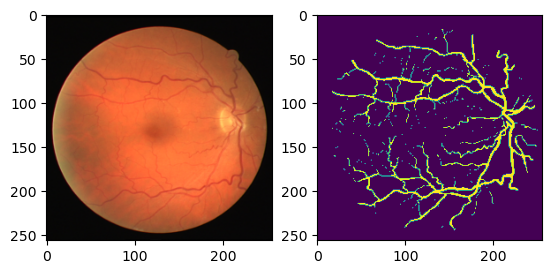

In [11]:
im,label = custom_dataset[1]
print(im.size())
print(label.size())

plt.figure()
plt.subplot(1,2,1)
plt.imshow(im.permute(1, 2, 0))
plt.subplot(1,2,2)
plt.imshow(label[0,:,:])


In [13]:
class CNN(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(CNN, self).__init__()
        f = [10,20,30,20,10,out_channels]
# Input to conv1 will be image of shape [batch_size,1,img_size,img_size]
        self.conv1 = nn.Sequential(   
            nn.Conv2d(in_channels=in_channels,out_channels=f[0],kernel_size=(3,3),padding=1), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=(2,2)) 
        )
        self.conv2 = nn.Sequential( 
            nn.Conv2d(in_channels=f[0],out_channels=f[1],kernel_size=(3,3),padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)) 
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=f[1],out_channels=f[2],kernel_size=(3,3),padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=f[2],out_channels=f[2],kernel_size=(3,3),padding=1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=f[2],out_channels=f[3],kernel_size=(3,3),padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2))
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=f[3],out_channels=f[4],kernel_size=(3,3),padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2))
        
        
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=f[4],out_channels=f[5],kernel_size=(1,1)),
            nn.Sigmoid()
        )
            

    def forward(self, x,plot=False):

        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)
        x6 = self.conv6(x5)
        
        if plot:
            print('Input shape', x.shape)
            print('After layer 1', x1.shape)
            print('After layer 2', x2.shape)
            print('After layer 3', x3.shape)
            print('After layer 4', x4.shape)
            print('After layer 5', x5.shape)
            print('After layer 6', x6.shape)

        return x6

model = CNN(in_channels=3, out_channels=1)

In [14]:
learning_rate = 0.001

optimizer = optim.Adam(model.parameters(), lr = learning_rate)   
loss_func = nn.BCELoss()   

In [15]:
from torch.autograd import Variable

num_epochs = 200

def train(num_epochs, model, train_loader):
    
    model.train()
        
    # Train the model
    total_step = len(train_loader)
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = model(b_x)  
            #loss = loss_func(torch.squeeze(output), torch.squeeze(b_y))
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()                # apply gradients             
            optimizer.step()                
            
            if (i+1) % 2 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))               
        
    
    
train(num_epochs, model, train_loader)

Epoch [1/200], Step [2/5], Loss: 0.7112
Epoch [1/200], Step [4/5], Loss: 0.7001
Epoch [2/200], Step [2/5], Loss: 0.6796
Epoch [2/200], Step [4/5], Loss: 0.6550
Epoch [3/200], Step [2/5], Loss: 0.5812
Epoch [3/200], Step [4/5], Loss: 0.4693
Epoch [4/200], Step [2/5], Loss: 0.3687
Epoch [4/200], Step [4/5], Loss: 0.4133
Epoch [5/200], Step [2/5], Loss: 0.3700
Epoch [5/200], Step [4/5], Loss: 0.3296
Epoch [6/200], Step [2/5], Loss: 0.3174
Epoch [6/200], Step [4/5], Loss: 0.3413
Epoch [7/200], Step [2/5], Loss: 0.3303
Epoch [7/200], Step [4/5], Loss: 0.2999
Epoch [8/200], Step [2/5], Loss: 0.3063
Epoch [8/200], Step [4/5], Loss: 0.3156
Epoch [9/200], Step [2/5], Loss: 0.2866
Epoch [9/200], Step [4/5], Loss: 0.2599
Epoch [10/200], Step [2/5], Loss: 0.2651
Epoch [10/200], Step [4/5], Loss: 0.2850
Epoch [11/200], Step [2/5], Loss: 0.2555
Epoch [11/200], Step [4/5], Loss: 0.2509
Epoch [12/200], Step [2/5], Loss: 0.2580
Epoch [12/200], Step [4/5], Loss: 0.2633
Epoch [13/200], Step [2/5], Loss: 

Epoch [199/200], Step [4/5], Loss: 0.1942
Epoch [200/200], Step [2/5], Loss: 0.1872
Epoch [200/200], Step [4/5], Loss: 0.1819


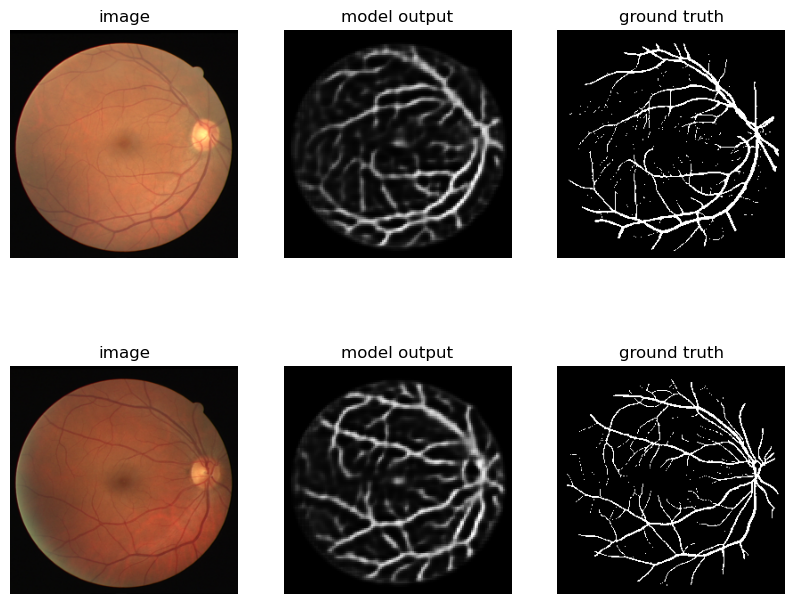

In [17]:
test_dataset = CustomDataset(test_paths)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=4, 
                                           shuffle=False)
dataset = test_dataset

with torch.no_grad():
    figure = plt.figure(figsize=(10, 8))
    rows = 2
    for i in range(0, rows):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]
        b_x = img.unsqueeze(0)
        output = model(b_x)

        figure.add_subplot(rows, 3, 3*i + 1)
        plt.axis("off")
        plt.imshow(img.permute(1,2,0))
        plt.title("image")
        figure.add_subplot(rows, 3, 3*i + 2)
        plt.axis("off")
        plt.imshow(torch.squeeze(output), cmap="gray")
        plt.title("model output")
        figure.add_subplot(rows, 3, 3*i + 3)
        plt.axis("off")
        plt.imshow(torch.squeeze(label), cmap="gray")
        plt.title("ground truth")
    plt.show()

## 5. Image Denoising with MNIST

- Problem setup: Suppose we have an observed noisy image $x$, and we wish to recover a clean version of the image, $u$. We model using additive gaussian noise: $x = u + \epsilon$ where $\epsilon$ is the noise.
- Let us set the data up, by extracting the MNIST images and adding gaussian noise to them.

In [20]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

torch.Size([60000, 28, 28])


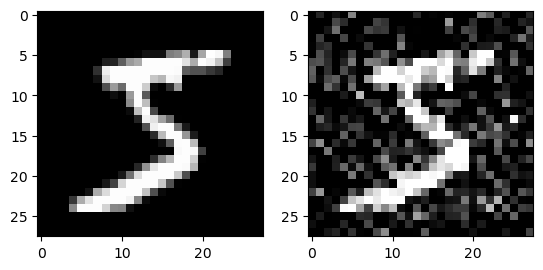

In [21]:

train_imgs = train_data.data
print(train_imgs.shape)
train_imgs = train_imgs.numpy() # pixel of 0 is black, pixel of 255 is white
# store the clean images before adding noise
train_imgs0 = train_imgs/255.0 # [0,1]

test_imgs = test_data.data
test_imgs = test_imgs.numpy()
test_imgs0 = test_imgs/255.0

sigma = 70/255.0 # noise level
train_imgs = (train_imgs/255.0 + np.random.normal(0,sigma,train_imgs.shape)).clip(0,1)
test_imgs = (test_imgs/255.0 + np.random.normal(0,sigma,test_imgs.shape)).clip(0,1)


fig = plt.figure()
plt.subplot(1,2,1)
plt.imshow(train_imgs0[0],cmap='gray')
plt.subplot(1,2,2)
plt.imshow(train_imgs[0],cmap='gray')
plt.show()



In [22]:
model = CNN(in_channels=1, out_channels = 1).to(device)

In [23]:
learning_rate = 0.001

optimizer = optim.Adam(model.parameters(), lr = learning_rate)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [24]:
total_step = len(train_imgs)
print(total_step)
train_imgs.shape

60000


(60000, 28, 28)

In [25]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_imgs, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_imgs, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x15e183ef670>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x15e183ee020>}

## Loss Function:

- In our denoising setup we assume no label. Our dataset consists of only observed noisy images, i.e. $\mathcal{D} = \{ \mathbf{x}_i \in \mathbb{R}^{h \times w} \}_{k=1}^n$. This approach (not using labels) is known as **unsupervised learning**.

- We will implement a classic denoising model, which is composed of two terms:
$$ \mathcal{L}(\theta) = \sum_{k=1}^n || \nabla f(\mathbf{x}_i;\theta) ||_2 + \frac{\lambda}{2} || f(\mathbf{x}_i; \theta) - \mathbf{x}_i ||_2^2 , $$
- where $\lambda>0$ is a parameter which we hand tune according to the strength of noise. If we have a large $\lambda$, the second term is more dominiant and our network output will be matched more closely to the input (i.e. $f(\mathbf{x}_i ; \theta) \approx \mathbf{x}_i$). If $\lambda$ is small, the first term will be more dominant and more smoothing will occur.

In [26]:
def up_shift(f):
    g = torch.zeros_like(f)
    g[:-1, :] = f[1:, :] #i.e. g[0,:] = f[1,:], g[1,:] = f[2,:], ..., g[i,:] = f[i+1,:]
    g[-1, :] = f[-1, :]
    return g

def down_shift(f):
    g = torch.zeros_like(f)
    g[1:, :] = f[:-1, :]
    g[0, :] = f[0, :]
    return g

def left_shift(f):
    g = torch.zeros_like(f)
    g[:, :-1] = f[:, 1:]
    g[:, -1] = f[:, -1]
    return g

def right_shift(f):
    g = torch.zeros_like(f)
    g[:, 1:] = f[:, :-1]
    g[:, 0] = f[:, 0]
    return g


def grad(f):
    f_x = (left_shift(f) - right_shift(f))/2
    f_y = (down_shift(f) - up_shift(f))/2
    
    return torch.sqrt(f_x**2 + f_y**2 + 1e-7)

class denoising_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, denoised, noisy, lambdaP):
        
        TV_term = grad(denoised)
        
        Fit_Term = (denoised-noisy)**2
        
        loss = TV_term.mean() + (lambdaP/2)*Fit_Term.mean()

        return loss

In [27]:
from torch.autograd import Variable
num_epochs = 10
lambdaP = 8
loss_func = denoising_loss()
def train(num_epochs, model, loaders):
    
    model.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, images in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images, requires_grad=True).to(device)   # batch x. b_x is of shape [100,28,28]
            #print(b_x.shape)
            b_x = b_x.unsqueeze(1) # make dimensions [100,1,28,28], rather than [100,28,28]
            #print(b_x.shape)
            output = model(b_x.float())  

            #print(output.shape)
            loss = loss_func(output,b_x,lambdaP)
                        
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()                # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))               
        
    
    
train(num_epochs, model, loaders)

Epoch [1/10], Step [100/600], Loss: 0.2709
Epoch [1/10], Step [200/600], Loss: 0.2480
Epoch [1/10], Step [300/600], Loss: 0.2519
Epoch [1/10], Step [400/600], Loss: 0.2348
Epoch [1/10], Step [500/600], Loss: 0.2332
Epoch [1/10], Step [600/600], Loss: 0.2246
Epoch [2/10], Step [100/600], Loss: 0.2230
Epoch [2/10], Step [200/600], Loss: 0.2252
Epoch [2/10], Step [300/600], Loss: 0.2221
Epoch [2/10], Step [400/600], Loss: 0.2183
Epoch [2/10], Step [500/600], Loss: 0.2138
Epoch [2/10], Step [600/600], Loss: 0.2213
Epoch [3/10], Step [100/600], Loss: 0.2212
Epoch [3/10], Step [200/600], Loss: 0.2228
Epoch [3/10], Step [300/600], Loss: 0.2174
Epoch [3/10], Step [400/600], Loss: 0.2150
Epoch [3/10], Step [500/600], Loss: 0.2156
Epoch [3/10], Step [600/600], Loss: 0.2123
Epoch [4/10], Step [100/600], Loss: 0.2166
Epoch [4/10], Step [200/600], Loss: 0.2142
Epoch [4/10], Step [300/600], Loss: 0.2141
Epoch [4/10], Step [400/600], Loss: 0.2162
Epoch [4/10], Step [500/600], Loss: 0.2138
Epoch [4/10

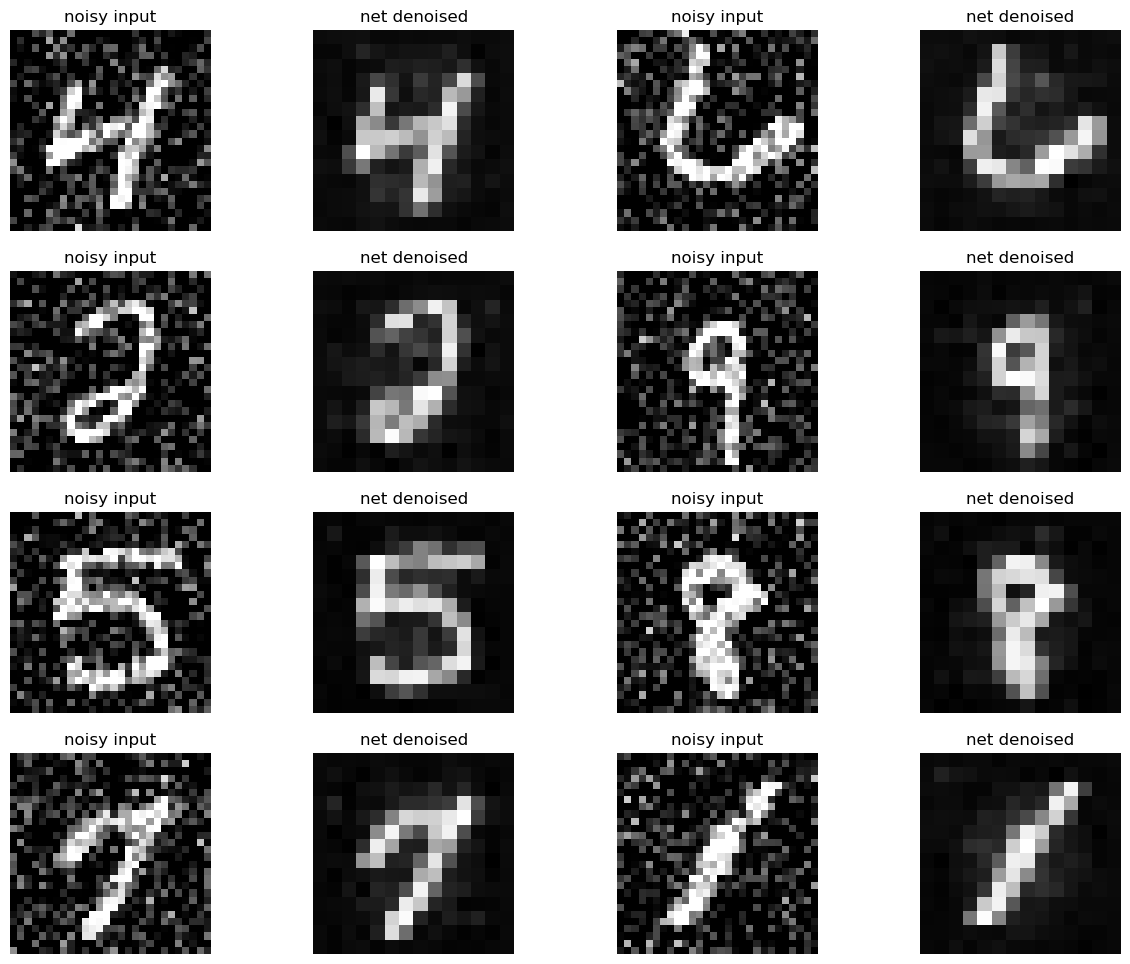

In [28]:
with torch.no_grad():
    #Plot multiple
    figure = plt.figure(figsize=(15, 12))
    cols, rows =4,4
    for i in range(1, int((cols * rows)/2) + 1):
        sample_idx = torch.randint(len(test_imgs), size=(1,)).item()
        noisy, clean = test_imgs[sample_idx], test_imgs0[sample_idx]
        noisy = noisy[np.newaxis,np.newaxis,:,:] #[1,1,height,width]
        b_x = torch.from_numpy(noisy).float()
        b_x = b_x.to(device)
        output = model(b_x)
        output = output.cpu()

        figure.add_subplot(rows,cols,2*i - 1)
        plt.title('noisy input')
        plt.axis("off")
        plt.imshow(noisy.squeeze(),cmap="gray")

        figure.add_subplot(rows,cols,2*i)
        plt.title('net denoised')
        plt.axis("off")
        plt.imshow(output.squeeze(),cmap="gray")

    plt.show()

## Homework

- Try training the segmentation problem again with DICE loss function.
- The DICE coefficient is a measure of how well two sets coincide with one another, i.e. how well two segmentation results are similar. We use the output of our network, $u$, and the ground truth, $GT$, to measure performance.
$$ DICE(u,GT) = \frac{ 2 \cdot | u \cdot GT |}{|u| + |GT|} $$
<p align="center">
<img src="dice.png" width="250" title="DICE." >
</p> 

- A score of 1 is a perfect match, whereas a score of 0 is the opposite. We want a score of 1 in segmentation.
- To use this in a loss function, the loss function looks like:
$$ DICELOSS(u,GT) = 1 - DICE(u,GT) $$

In [4]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        ###comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        ###flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice